In [1]:
# Cell 1: Load dataset and preprocess for BiLSTM

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv("dataset.csv")  # Make sure dataset.csv has 'phrase' and 'sentiment'

# Optional: shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Features and labels
X = df['phrase'].values
y = df['sentiment'].values

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Hot->0, Cold->1, Dead->2 (for example)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))
print("Classes:", le.classes_)


Number of training samples: 2783
Number of test samples: 696
Classes: ['Cold' 'Dead' 'Hot']


In [2]:
# Cell 2: Tokenization, padding, and DataLoader creation

import torch
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Parameters
MAX_WORDS = 10000       # Max vocabulary size
MAX_LEN = 50            # Max sequence length
BATCH_SIZE = 32

# 1 — Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# 2 — Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 3 — Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Custom Dataset Class
class TweetDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = TweetDataset(X_train_tensor, y_train_tensor)
test_dataset = TweetDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Vocabulary size:", min(MAX_WORDS, len(tokenizer.word_index)))
print("Training batches:", len(train_loader))
print("Testing batches:", len(test_loader))


Vocabulary size: 4265
Training batches: 87
Testing batches: 22


In [3]:
# Cell 3: BiLSTM Model + Training Loop

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# -----------------------------
# 1 — Define BiLSTM Model
# -----------------------------
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(BiLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1,
                            batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for Bi-direction
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])   # Last hidden state
        return self.fc(out)

# Model parameters
VOCAB_SIZE = min(MAX_WORDS, len(tokenizer.word_index) + 1)
EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_CLASSES = 3

model = BiLSTM(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASSES)

# -----------------------------
# 2 — Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 3 — Training Loop
# -----------------------------
EPOCHS = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Training on:", device)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)

    # -----------------------------
    # Validation
    # -----------------------------
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining complete!")


Training on: cuda
Epoch [1/10] Train Loss: 95.4268, Train Acc: 0.3658 | Val Loss: 24.0711, Val Acc: 0.3707
Epoch [2/10] Train Loss: 95.1928, Train Acc: 0.3640 | Val Loss: 24.0785, Val Acc: 0.3707
Epoch [3/10] Train Loss: 94.9461, Train Acc: 0.3719 | Val Loss: 24.0555, Val Acc: 0.3707
Epoch [4/10] Train Loss: 94.4397, Train Acc: 0.3723 | Val Loss: 23.4667, Val Acc: 0.3707
Epoch [5/10] Train Loss: 89.4225, Train Acc: 0.4635 | Val Loss: 21.5184, Val Acc: 0.4928
Epoch [6/10] Train Loss: 84.2738, Train Acc: 0.5013 | Val Loss: 19.8267, Val Acc: 0.5489
Epoch [7/10] Train Loss: 71.3127, Train Acc: 0.5810 | Val Loss: 18.4712, Val Acc: 0.5589
Epoch [8/10] Train Loss: 61.6763, Train Acc: 0.6152 | Val Loss: 18.1050, Val Acc: 0.6034
Epoch [9/10] Train Loss: 56.5895, Train Acc: 0.6331 | Val Loss: 17.1702, Val Acc: 0.6034
Epoch [10/10] Train Loss: 52.9475, Train Acc: 0.6493 | Val Loss: 17.4890, Val Acc: 0.6121

Training complete!


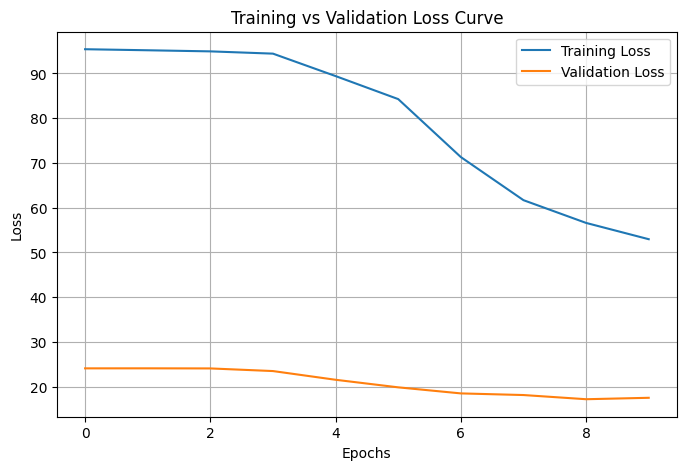

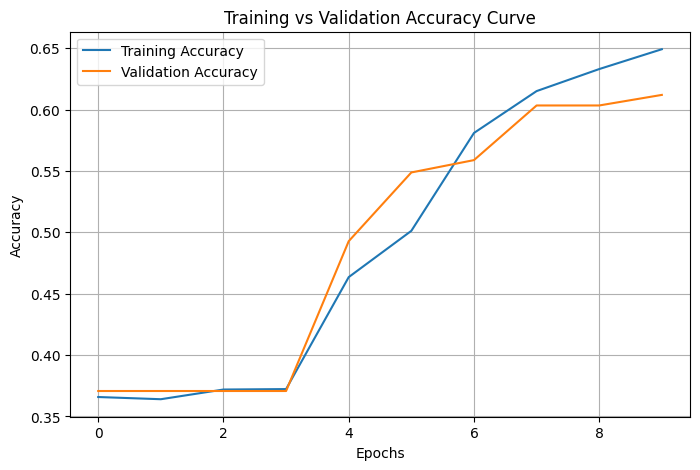

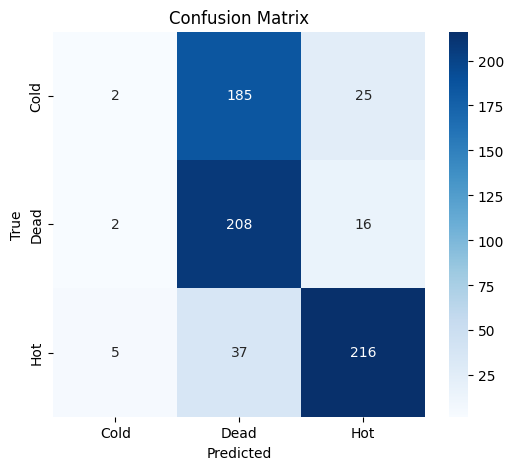


Classification Report:
              precision    recall  f1-score   support

        Cold       0.22      0.01      0.02       212
        Dead       0.48      0.92      0.63       226
         Hot       0.84      0.84      0.84       258

    accuracy                           0.61       696
   macro avg       0.52      0.59      0.50       696
weighted avg       0.54      0.61      0.52       696


Per-Class Accuracy:
Cold: 0.0094
Dead: 0.9204
Hot: 0.8372


In [4]:
# Cell 4: Evaluation Graphs & Metrics

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# -------------------------------
# 1 — Plot Training & Validation Loss
# -------------------------------

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 2 — Plot Training & Validation Accuracy
# -------------------------------

plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 3 — Confusion Matrix
# -------------------------------

# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# 4 — Classification Report
# -------------------------------

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# -------------------------------
# 5 — Compute Per-Class Accuracy
# -------------------------------

class_correct = cm.diagonal()
class_totals = cm.sum(axis=1)
class_accuracy = class_correct / class_totals

print("\nPer-Class Accuracy:")
for label, acc in zip(le.classes_, class_accuracy):
    print(f"{label}: {acc:.4f}")
